In [1]:
# Type of GPU
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Select the Runtime → "Change runtime type" menu to enable a GPU accelerator, ')
  print('and then re-execute this cell.')
else:
  print(gpu_info)

Wed Aug  5 03:51:05 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 450.57       Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   34C    P0    27W / 250W |      0MiB / 16280MiB |      0%      Default |
|                               |                      |                 ERR! |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [2]:
# Memory
from psutil import virtual_memory
ram_gb = virtual_memory().total / 1e9
print('Your runtime has {:.1f} gigabytes of available RAM\n'.format(ram_gb))

if ram_gb < 20:
  print('To enable a high-RAM runtime, select the Runtime → "Change runtime type"')
  print('menu, and then select High-RAM in the Runtime shape dropdown. Then, ')
  print('re-execute this cell.')
else:
  print('You are using a high-RAM runtime!')

Your runtime has 27.4 gigabytes of available RAM

You are using a high-RAM runtime!


In [3]:
# Mount my Google Drive. 
from google.colab import drive 
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [4]:
# Copy over the preprocess.py and labels from Google Drive.
!cp drive/'My Drive'/Colab\ Notebooks/CS698/preprocess.py ./
!cp -r drive/'My Drive'/Colab\ Notebooks/CS698/label_data ./

In [5]:
%load_ext autoreload
%autoreload 2

from preprocess import *
import keras
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPooling2D
from keras.utils import to_categorical

In [6]:
import random
RS = 41
random.seed(RS)
np.random.seed(RS)

In [7]:
INPUT_DATA_NAME = 'lang30_region'

if INPUT_DATA_NAME == 'lang30_region': 
  !cp drive/'My Drive'/Colab\ Notebooks/CS698/selected_utterances_10000.tgz ./
  # Unzip the utterance wav files. 
  !tar -xzf selected_utterances_10000.tgz
  print('number of utterances:')
  !ls ./selected_utterances_lang30_region/ | wc -w # 10000
  !rm selected_utterances_10000.tgz
else:
  # Copy over the utterance wav files and labels from Google Drive.
  !cp drive/'My Drive'/Colab\ Notebooks/CS698/selected_utterances.tgz ./
  !tar -xzf selected_utterances.tgz
  print('number of utterances:')
  !ls ./selected_utterances_lang70_region_v1.5/ | wc -w # 50000
  !rm selected_utterances.tgz

number of utterances:
10000


In [8]:
# True: to calculate mfcc/log_mel from wav, False: to bring previously gotten mfcc/log_mel from Google Drive. 
SAVE_FEATURE = False

# mfcc/log_mel
FEATURE_TYPE = 'log_mel'

# If SAVE_FEATURE is False, then specify the feature set below. 
INPUT_SUBSET = 'feature_set_3_5'

if not SAVE_FEATURE:  
  # Set the folder name as needed !! 
  !cp -r drive/'My Drive'/Colab\ Notebooks/CS698/feature_set_3_5 ./
  print('Copied over the feature_set.')
else: 
  !cp -r drive/'My Drive'/Colab\ Notebooks/CS698/feature_dir ./
  !cp -r drive/'My Drive'/Colab\ Notebooks/CS698/pickles_dir ./
  print('Created empty feature_dir and pickles_dir.')

Copied over the feature_set.


In [9]:
if INPUT_DATA_NAME == 'lang30_region': 
  WAV_PATH = "./selected_utterances_" + INPUT_DATA_NAME
else: 
  WAV_PATH = "./selected_utterances_" + INPUT_DATA_NAME + "_v1.5"

LABELS_TABLE_PATH = "label_data/" + INPUT_DATA_NAME + ".csv"

# FEATURE_PATH
if not SAVE_FEATURE: 
  FEATURE_PATH = INPUT_SUBSET + "/" + FEATURE_TYPE + ".npy"
else:
  FEATURE_PATH = "feature_dir/" + FEATURE_TYPE + ".npy"
print('FEATURE_PATH:', FEATURE_PATH)

# Set 20 for mfcc, 128 for log_mel !!  
FEATURE_HEIGHT = 128
MAX_LEN_TIME = 75
CHANNEL = 1

FEATURE_PATH: feature_set_3_5/log_mel.npy


In [10]:
# Save features and get labels. 
import pickle

if SAVE_FEATURE: 
  # Create features and labels. 
  labels, label_map = save_features_and_get_labels(WAV_PATH, LABELS_TABLE_PATH, FEATURE_TYPE, 
                                                 SAVE_FEATURE, FEATURE_PATH,  
                                                 FEATURE_HEIGHT, MAX_LEN_TIME)
  with open('pickles_dir/labels.pickle', 'wb') as f:
    pickle.dump(labels , f)
  with open('pickles_dir/label_map.pickle', 'wb') as f:
    pickle.dump(label_map , f)
  # Save to Google Drive. 
  !cp -r feature_dir drive/My\ Drive/Colab\ Notebooks/CS698/feature_created/
  !cp -r pickles_dir drive/'My Drive'/Colab\ Notebooks/CS698/pickles_created/
else: 
  # Set the pickles dir name !!  
  !cp -r drive/'My Drive'/Colab\ Notebooks/CS698/feature_set_3_5_pickles ./ 
  with open(INPUT_SUBSET + '_pickles/labels.pickle', 'rb') as f:
    labels = pickle.load(f)
  with open(INPUT_SUBSET + '_pickles/label_map.pickle', 'rb') as f:
    label_map = pickle.load(f)

In [11]:
NUM_CLASSES = len(label_map)
print(NUM_CLASSES)

124


In [12]:
# Train test split
X_train, X_test, y_train, y_test = get_train_test(FEATURE_PATH, labels, 0.1, RS)
print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

(9000, 128, 75) (1000, 128, 75) (9000, 1) (1000, 1)


In [13]:
# Check distribution. 
y_train_df = pd.DataFrame(y_train)
y_train_df.shape

(9000, 1)

In [14]:
# Check the distribution of labels, and create label_list and label_names. 
s = y_train_df.loc[:, 0].value_counts()
label_list = list(s.index)
label_names = [label_map[v] for v in label_list]
print(type(s))
print('# classes:', len(s))
print(s)
print(label_map)
print(label_list)
print(label_names)

<class 'pandas.core.series.Series'>
# classes: 29
69     922
76     893
54     835
66     822
73     638
53     581
17     475
39     437
49     400
95     258
19     255
120    243
97     239
37     194
50     179
20     173
40     169
56     156
29     145
109    136
96     125
116    121
101    108
91     100
115     99
58      95
38      91
86      68
8       43
Name: 0, dtype: int64
['Arabic' 'Bengali' 'Cantonese' 'Chinese' 'Creole' 'Eng_AK' 'Eng_AL'
 'Eng_AR' 'Eng_AZ' 'Eng_Afghanistan' 'Eng_Algeria' 'Eng_American Samoa'
 'Eng_Angola' 'Eng_Australia' 'Eng_Barbados' 'Eng_Belize' 'Eng_Brazil'
 'Eng_CA' 'Eng_CO' 'Eng_CT' 'Eng_Canada' 'Eng_Cape Verde' 'Eng_Costa Rica'
 'Eng_DC' 'Eng_DE' 'Eng_Dominica' 'Eng_Ecuador' 'Eng_FL' 'Eng_France'
 'Eng_GA' 'Eng_Georgia' 'Eng_Germany' 'Eng_Ghana' 'Eng_Guam' 'Eng_Guyana'
 'Eng_HI' 'Eng_Haiti' 'Eng_IA' 'Eng_ID' 'Eng_IL' 'Eng_IN' 'Eng_India'
 'Eng_Indonesia' 'Eng_Ireland' 'Eng_Israel' 'Eng_Ivory Coast'
 'Eng_Jamaica' 'Eng_Japan' 'Eng_Jordan' 'Eng_K

In [15]:
# Reshape to perform 2D convolution. 
X_train = X_train.reshape(X_train.shape[0], FEATURE_HEIGHT, MAX_LEN_TIME, CHANNEL)
X_test = X_test.reshape(X_test.shape[0], FEATURE_HEIGHT, MAX_LEN_TIME, CHANNEL)

# If loss is set to sparse_categorical_crossentropy, we don't need this. 
# y_train_cat = to_categorical(y_train, num_classes=NUM_CLASSES)
# print(y_dev[:3])
# y_test_cat = to_categorical(y_test, num_classes=NUM_CLASSES)
# print(y_dev[:3])

In [16]:
import tensorflow as tf
tf.random.set_seed(RS)

In [17]:
EPOCHS = 200
BATCH_SIZE = 64
LEARNING_RATE = 0.0005

In [18]:
!cp -r drive/'My Drive'/Colab\ Notebooks/CS698/models ./
# Set model file name. 
model_path = 'models/model_2_2_L2_7.h5'

In [19]:
from keras import regularizers
from keras.layers import BatchNormalization

def get_model(filter_size, lambd):
    model = Sequential()

    l2 = None if lambd is None else regularizers.l2(lambd)
    if l2 is not None:
        print('Using L2 regularization - lambd: {:.4f}'.format(lambd)) 

    # # Arch_1
    # model.add(Conv2D(32, kernel_size=(3, 3), padding='same', activation='relu', input_shape=(FEATURE_HEIGHT, MAX_LEN_TIME, CHANNEL)))
    # model.add(MaxPooling2D(pool_size=(2, 2)))
    # model.add(Conv2D(32, kernel_size=(3, 3), padding='same', activation='relu'))
    # model.add(MaxPooling2D(pool_size=(2, 2)))
    # model.add(Flatten())
    # model.add(Dense(256, activation='relu'))
    # model.add(Dense(NUM_CLASSES, activation='softmax'))

    # # Arch_0_1
    # model.add(Conv2D(32, kernel_size=(filter_size, filter_size), padding='same', activation='relu', input_shape=(FEATURE_HEIGHT, MAX_LEN_TIME, CHANNEL)))
    # model.add(MaxPooling2D(pool_size=(2, 2)))
    # model.add(Conv2D(48, kernel_size=(filter_size, filter_size), padding='same', activation='relu'))
    # model.add(MaxPooling2D(pool_size=(2, 2)))
    # model.add(Conv2D(120, kernel_size=(filter_size, filter_size), padding='same', activation='relu'))
    # model.add(MaxPooling2D(pool_size=(2, 2)))
    # model.add(Flatten())
    # model.add(Dense(128, activation='relu'))
    # model.add(Dense(64, activation='relu'))
    # model.add(Dense(32, activation='relu'))
    # model.add(Dense(NUM_CLASSES, activation='softmax'))

    # # Arch_0_4
    # model.add(Conv2D(32, kernel_size=(filter_size, filter_size), padding='same', activation='relu', input_shape=(FEATURE_HEIGHT, MAX_LEN_TIME, CHANNEL)))
    # model.add(MaxPooling2D(pool_size=(2, 2)))
    # model.add(Conv2D(48, kernel_size=(filter_size, filter_size), padding='same', activation='relu'))
    # model.add(MaxPooling2D(pool_size=(2, 2)))
    # model.add(Conv2D(120, kernel_size=(filter_size, filter_size), padding='same', activation='relu'))
    # model.add(MaxPooling2D(pool_size=(2, 2)))
    # model.add(Flatten())
    # model.add(Dense(128, activation='relu'))
    # model.add(Dense(NUM_CLASSES, activation='softmax'))

    # # Arch_2_2
    # model.add(Conv2D(16, kernel_size=(filter_size, filter_size), padding='same', activation='relu', kernel_regularizer=l2, 
    #                  input_shape=(FEATURE_HEIGHT, MAX_LEN_TIME, CHANNEL)))
    # model.add(MaxPooling2D(pool_size=(2, 2)))
    # model.add(Conv2D(32, kernel_size=(filter_size, filter_size), padding='same', activation='relu', kernel_regularizer=l2))
    # model.add(MaxPooling2D(pool_size=(2, 2)))
    # model.add(Conv2D(64, kernel_size=(filter_size, filter_size), padding='same', activation='relu', kernel_regularizer=l2))
    # model.add(MaxPooling2D(pool_size=(2, 2)))
    # model.add(Conv2D(128, kernel_size=(filter_size, filter_size), padding='same', activation='relu', kernel_regularizer=l2))
    # model.add(MaxPooling2D(pool_size=(2, 2)))
    # model.add(Flatten())
    # model.add(Dense(128, activation='relu', kernel_regularizer=l2))
    # model.add(Dense(64, activation='relu', kernel_regularizer=l2))
    # model.add(Dense(32, activation='relu', kernel_regularizer=l2))
    # model.add(Dense(NUM_CLASSES, activation='softmax'))

    # Arch_2_2_b
    model.add(Conv2D(16, kernel_size=(filter_size, filter_size), padding='same', activation='relu', kernel_regularizer=l2, 
                     input_shape=(FEATURE_HEIGHT, MAX_LEN_TIME, CHANNEL)))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Conv2D(32, kernel_size=(filter_size, filter_size), padding='same', activation='relu', kernel_regularizer=l2))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.2))
    model.add(Conv2D(64, kernel_size=(filter_size, filter_size), padding='same', activation='relu', kernel_regularizer=l2))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Conv2D(128, kernel_size=(filter_size, filter_size), padding='same', activation='relu', kernel_regularizer=l2))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.2))
    model.add(Flatten())
    model.add(Dense(128, activation='relu', kernel_regularizer=l2))
    model.add(Dropout(0.2))
    model.add(Dense(64, activation='relu', kernel_regularizer=l2))
    model.add(Dropout(0.2))
    model.add(Dense(32, activation='relu', kernel_regularizer=l2))
    model.add(Dropout(0.2))
    model.add(Dense(NUM_CLASSES, activation='softmax'))

    # # Arch_2_2_c
    # model.add(Conv2D(16, kernel_size=(filter_size, filter_size), padding='same', activation='relu', kernel_regularizer=l2, 
    #                  input_shape=(FEATURE_HEIGHT, MAX_LEN_TIME, CHANNEL)))
    # model.add(MaxPooling2D(pool_size=(2, 2)))
    # model.add(BatchNormalization())
    # model.add(Conv2D(32, kernel_size=(filter_size, filter_size), padding='same', activation='relu', kernel_regularizer=l2))
    # model.add(MaxPooling2D(pool_size=(2, 2)))
    # model.add(Dropout(0.2))
    # model.add(BatchNormalization())
    # model.add(Conv2D(64, kernel_size=(filter_size, filter_size), padding='same', activation='relu', kernel_regularizer=l2))
    # model.add(MaxPooling2D(pool_size=(2, 2)))
    # model.add(BatchNormalization())
    # model.add(Conv2D(128, kernel_size=(filter_size, filter_size), padding='same', activation='relu', kernel_regularizer=l2))
    # model.add(MaxPooling2D(pool_size=(2, 2)))
    # model.add(Dropout(0.2))
    # model.add(Flatten())
    # model.add(BatchNormalization())
    # model.add(Dense(128, activation='relu', kernel_regularizer=l2))
    # model.add(Dropout(0.2))
    # model.add(BatchNormalization())
    # model.add(Dense(64, activation='relu', kernel_regularizer=l2))
    # model.add(Dropout(0.2))
    # model.add(BatchNormalization())
    # model.add(Dense(32, activation='relu', kernel_regularizer=l2))
    # model.add(Dropout(0.2))
    # model.add(BatchNormalization())
    # model.add(Dense(NUM_CLASSES, activation='softmax'))

    # # Arch_2_3
    # model.add(Conv2D(16, kernel_size=(filter_size, filter_size), padding='same', activation='relu', input_shape=(FEATURE_HEIGHT, MAX_LEN_TIME, CHANNEL)))
    # model.add(MaxPooling2D(pool_size=(2, 2)))
    # model.add(Conv2D(32, kernel_size=(filter_size, filter_size), padding='same', activation='relu'))
    # model.add(MaxPooling2D(pool_size=(2, 2)))
    # model.add(Conv2D(64, kernel_size=(filter_size, filter_size), padding='same', activation='relu'))
    # model.add(MaxPooling2D(pool_size=(2, 2)))
    # model.add(Conv2D(128, kernel_size=(filter_size, filter_size), padding='same', activation='relu'))
    # model.add(MaxPooling2D(pool_size=(2, 2)))
    # model.add(Flatten())
    # model.add(Dense(128, activation='relu'))
    # model.add(Dense(NUM_CLASSES, activation='softmax'))

    # # Arch_2_4
    # model.add(Conv2D(16, kernel_size=(filter_size, filter_size), padding='same', activation='relu', input_shape=(FEATURE_HEIGHT, MAX_LEN_TIME, CHANNEL)))
    # model.add(MaxPooling2D(pool_size=(2, 2)))
    # model.add(Conv2D(32, kernel_size=(filter_size, filter_size), padding='same', activation='relu'))
    # model.add(MaxPooling2D(pool_size=(2, 2)))
    # model.add(Conv2D(64, kernel_size=(filter_size, filter_size), padding='same', activation='relu'))
    # model.add(MaxPooling2D(pool_size=(2, 2)))
    # model.add(Conv2D(128, kernel_size=(filter_size, filter_size), padding='same', activation='relu'))
    # model.add(MaxPooling2D(pool_size=(2, 2)))
    # model.add(Flatten())
    # model.add(Dense(256, activation='relu'))
    # model.add(Dense(128, activation='relu'))
    # model.add(Dense(64, activation='relu'))
    # model.add(Dense(32, activation='relu'))
    # model.add(Dense(16, activation='relu'))
    # model.add(Dense(NUM_CLASSES, activation='softmax'))


    opt = keras.optimizers.Adam(learning_rate=LEARNING_RATE)
    model.compile(loss='sparse_categorical_crossentropy',
                  optimizer=opt,
                  metrics=['accuracy'])
    
    return model

In [20]:
# Load Tensorboard extension 
%load_ext tensorboard

import os, re, math, json, shutil, pprint
import PIL.Image, PIL.ImageFont, PIL.ImageDraw
import IPython.display as display
from matplotlib import pyplot as plt
import tensorflow as tf
print("Tensorflow version " + tf.__version__)

Tensorflow version 2.3.0


In [21]:
#@title visualization utilities [RUN ME]
"""
This cell contains helper functions used for visualization
and downloads only. You can skip reading it. There is very
little useful Keras/Tensorflow code here.
"""

# Matplotlib config
plt.ioff()
plt.rc('image', cmap='gray_r')
plt.rc('grid', linewidth=1)
plt.rc('xtick', top=False, bottom=False, labelsize='large')
plt.rc('ytick', left=False, right=False, labelsize='large')
plt.rc('axes', facecolor='F8F8F8', titlesize="large", edgecolor='white')
plt.rc('text', color='a8151a')
plt.rc('figure', facecolor='F0F0F0', figsize=(16,9))
# Matplotlib fonts
MATPLOTLIB_FONT_DIR = os.path.join(os.path.dirname(plt.__file__), "mpl-data/fonts/ttf")

# pull a batch from the datasets. This code is not very nice, it gets much better in eager mode (TODO)
def dataset_to_numpy_util(training_dataset, validation_dataset, N):
  
  # get one batch from each: 10000 validation digits, N training digits
  batch_train_ds = training_dataset.apply(tf.data.experimental.unbatch()).batch(N)
  
  # eager execution: loop through datasets normally
  if tf.executing_eagerly():
    for validation_digits, validation_labels in validation_dataset:
      validation_digits = validation_digits.numpy()
      validation_labels = validation_labels.numpy()
      break
    for training_digits, training_labels in batch_train_ds:
      training_digits = training_digits.numpy()
      training_labels = training_labels.numpy()
      break
    
  else:
    v_images, v_labels = validation_dataset.make_one_shot_iterator().get_next()
    t_images, t_labels = batch_train_ds.make_one_shot_iterator().get_next()
    # Run once, get one batch. Session.run returns numpy results
    with tf.Session() as ses:
      (validation_digits, validation_labels,
       training_digits, training_labels) = ses.run([v_images, v_labels, t_images, t_labels])
  
  # these were one-hot encoded in the dataset
  validation_labels = np.argmax(validation_labels, axis=1)
  training_labels = np.argmax(training_labels, axis=1)
  
  return (training_digits, training_labels,
          validation_digits, validation_labels)

# create digits from local fonts for testing
def create_digits_from_local_fonts(n):
  font_labels = []
  img = PIL.Image.new('LA', (28*n, 28), color = (0,255)) # format 'LA': black in channel 0, alpha in channel 1
  font1 = PIL.ImageFont.truetype(os.path.join(MATPLOTLIB_FONT_DIR, 'DejaVuSansMono-Oblique.ttf'), 25)
  font2 = PIL.ImageFont.truetype(os.path.join(MATPLOTLIB_FONT_DIR, 'STIXGeneral.ttf'), 25)
  d = PIL.ImageDraw.Draw(img)
  for i in range(n):
    font_labels.append(i%10)
    d.text((7+i*28,0 if i<10 else -4), str(i%10), fill=(255,255), font=font1 if i<10 else font2)
  font_digits = np.array(img.getdata(), np.float32)[:,0] / 255.0 # black in channel 0, alpha in channel 1 (discarded)
  font_digits = np.reshape(np.stack(np.split(np.reshape(font_digits, [28, 28*n]), n, axis=1), axis=0), [n, 28*28])
  return font_digits, font_labels

# utility to display a row of digits with their predictions
def display_digits(digits, predictions, labels, title, n):
  fig = plt.figure(figsize=(13,3))
  digits = np.reshape(digits, [n, 28, 28])
  digits = np.swapaxes(digits, 0, 1)
  digits = np.reshape(digits, [28, 28*n])
  plt.yticks([])
  plt.xticks([28*x+14 for x in range(n)], predictions)
  plt.grid(b=None)
  for i,t in enumerate(plt.gca().xaxis.get_ticklabels()):
    if predictions[i] != labels[i]: t.set_color('red') # bad predictions in red
  plt.imshow(digits)
  plt.grid(None)
  plt.title(title)
  display.display(fig)
  
# utility to display multiple rows of digits, sorted by unrecognized/recognized status
def display_top_unrecognized(digits, predictions, labels, n, lines):
  idx = np.argsort(predictions==labels) # sort order: unrecognized first
  for i in range(lines):
    display_digits(digits[idx][i*n:(i+1)*n], predictions[idx][i*n:(i+1)*n], labels[idx][i*n:(i+1)*n],
                   "{} sample validation digits out of {} with bad predictions in red and sorted first".format(n*lines, len(digits)) if i==0 else "", n)

def plot_learning_rate(lr_func, epochs):
  xx = np.arange(epochs+1, dtype=np.float)
  y = [lr_decay(x) for x in xx]
  fig, ax = plt.subplots(figsize=(9, 6))
  ax.set_xlabel('epochs')
  ax.set_title('Learning rate\ndecays from {:0.3g} to {:0.3g}'.format(y[0], y[-2]))
  ax.minorticks_on()
  ax.grid(True, which='major', axis='both', linestyle='-', linewidth=1)
  ax.grid(True, which='minor', axis='both', linestyle=':', linewidth=0.5)
  ax.step(xx,y, linewidth=3, where='post')
  display.display(fig)

class PlotTraining(tf.keras.callbacks.Callback):
  def __init__(self, sample_rate=1, zoom=1):
    self.sample_rate = sample_rate
    self.step = 0
    self.zoom = zoom
    self.steps_per_epoch = 60000//BATCH_SIZE

  def on_train_begin(self, logs={}):
    self.batch_history = {}
    self.batch_step = []
    self.epoch_history = {}
    self.epoch_step = []
    self.fig, self.axes = plt.subplots(1, 2, figsize=(16, 7))
    plt.ioff()

  def on_batch_end(self, batch, logs={}):
    if (batch % self.sample_rate) == 0:
      self.batch_step.append(self.step)
      for k,v in logs.items():
        # do not log "batch" and "size" metrics that do not change
        # do not log training accuracy "acc"
        if k=='batch' or k=='size':# or k=='acc':
          continue
        self.batch_history.setdefault(k, []).append(v)
    self.step += 1

  def on_epoch_end(self, epoch, logs={}):
    plt.close(self.fig)
    self.axes[0].cla()
    self.axes[1].cla()
      
    self.axes[0].set_ylim(0, 1.2/self.zoom)
    self.axes[1].set_ylim(1-1/self.zoom/2, 1+0.1/self.zoom/2)
    
    self.epoch_step.append(self.step)
    for k,v in logs.items():
      # only log validation metrics
      if not k.startswith('val_'):
        continue
      self.epoch_history.setdefault(k, []).append(v)

    display.clear_output(wait=True)
    
    for k,v in self.batch_history.items():
      self.axes[0 if k.endswith('loss') else 1].plot(np.array(self.batch_step) / self.steps_per_epoch, v, label=k)
      
    for k,v in self.epoch_history.items():
      self.axes[0 if k.endswith('loss') else 1].plot(np.array(self.epoch_step) / self.steps_per_epoch, v, label=k, linewidth=3)
      
    self.axes[0].legend()
    self.axes[1].legend()
    self.axes[0].set_xlabel('epochs')
    self.axes[1].set_xlabel('epochs')
    self.axes[0].minorticks_on()
    self.axes[0].grid(True, which='major', axis='both', linestyle='-', linewidth=1)
    self.axes[0].grid(True, which='minor', axis='both', linestyle=':', linewidth=0.5)
    self.axes[1].minorticks_on()
    self.axes[1].grid(True, which='major', axis='both', linestyle='-', linewidth=1)
    self.axes[1].grid(True, which='minor', axis='both', linestyle=':', linewidth=0.5)
    display.display(self.fig)

In [22]:
# Set filter size. 
filter_size = 5

# Set L2 regularization lambda. 
# lambd = None
lambd = 0.001

model = get_model(filter_size, lambd)

# Print model layers
model.summary()

# Utility callback that displays training curves
# plot_training = PlotTraining(sample_rate=10, zoom=1)

Using L2 regularization - lambd: 0.0010
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 128, 75, 16)       416       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 64, 37, 16)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 64, 37, 32)        12832     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 32, 18, 32)        0         
_________________________________________________________________
dropout (Dropout)            (None, 32, 18, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 32, 18, 64)        51264     
_________________________________________________________________
max_pooling2d_2 

In [23]:
from keras.callbacks import EarlyStopping, ModelCheckpoint

callbacks = [
            EarlyStopping(patience=50),
            ModelCheckpoint(model_path, save_best_only=True)
        ]

In [24]:
# steps_per_epoch = 1000//BATCH_SIZE  # 1,000 items in this dataset
# print("Steps per epoch: ", steps_per_epoch)
# model.fit(X_train, y_train, steps_per_epoch=steps_per_epoch, validation_steps=1, epochs=EPOCHS, verbose=1, validation_data=(X_val, y_val), callbacks=[plot_training])

# history = model.fit(X_train, y_train_cat, batch_size=BATCH_SIZE, epochs=EPOCHS, verbose=1, validation_split=0.1, shuffle=True, callbacks=callbacks)
history = model.fit(X_train, y_train, batch_size=BATCH_SIZE, epochs=EPOCHS, verbose=1, validation_split=0.1, shuffle=True, callbacks=callbacks)

Epoch 1/200
127/127 [==============================] - 2s 14ms/step - loss: 4.3958 - accuracy: 0.0764 - val_loss: 3.7489 - val_accuracy: 0.1000
Epoch 2/200
127/127 [==============================] - 2s 12ms/step - loss: 3.6265 - accuracy: 0.0973 - val_loss: 3.3341 - val_accuracy: 0.1389
Epoch 3/200
127/127 [==============================] - 2s 12ms/step - loss: 3.3367 - accuracy: 0.1304 - val_loss: 3.0571 - val_accuracy: 0.2000
Epoch 4/200
127/127 [==============================] - 2s 12ms/step - loss: 3.0754 - accuracy: 0.1738 - val_loss: 2.7540 - val_accuracy: 0.2700
Epoch 5/200
127/127 [==============================] - 2s 12ms/step - loss: 2.7711 - accuracy: 0.2515 - val_loss: 2.4307 - val_accuracy: 0.3400
Epoch 6/200
127/127 [==============================] - 2s 12ms/step - loss: 2.4627 - accuracy: 0.3212 - val_loss: 1.9788 - val_accuracy: 0.4922
Epoch 7/200
127/127 [==============================] - 2s 12ms/step - loss: 2.1660 - accuracy: 0.3979 - val_loss: 1.6874 - val_accuracy:

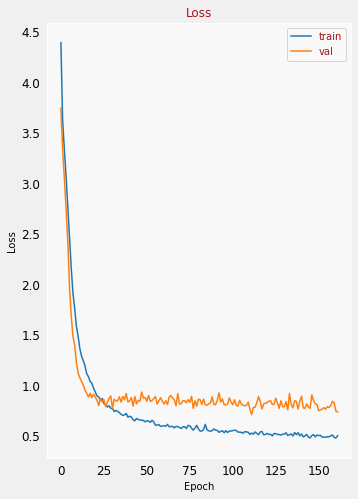

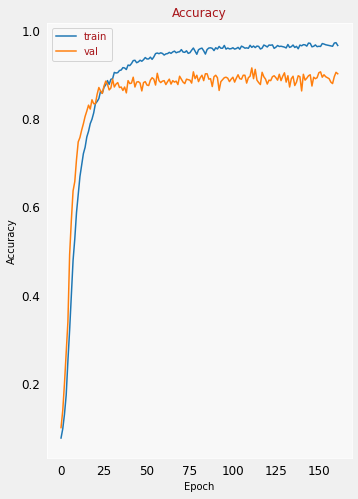

In [25]:
# Plot loss during training. 
plt.figure(figsize=(12, 8))
plt.subplot(121)
plt.title('Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='val')
plt.legend()
# Plot accuracy during training. 
plt.figure(figsize=(12, 8))
plt.subplot(122)
plt.title('Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.plot(history.history['accuracy'], label='train')
plt.plot(history.history['val_accuracy'], label='val')
plt.legend()
plt.show()

In [26]:
# Get Model Predictions for test data. 
from sklearn.metrics import classification_report

predicted_classes = model.predict_classes(X_test)
# print(predicted_classes)
# print(y_test)
d = classification_report(y_test, predicted_classes, labels=label_list, target_names=label_names, digits=4, output_dict=True)
print('accuracy:', d['accuracy'])

Instructions for updating:
Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
accuracy: 0.898


In [27]:
!cp -r drive/'My Drive'/Colab\ Notebooks/CS698/confusion_matrices ./
# Set cm file name. 
cm_path = 'confusion_matrices/cm_32.csv'
cm_df = pd.DataFrame(d).T
cm_df.head()

,precision,recall,f1-score,support
Eng_NY,0.878788,0.887755,0.883249,98.0
Eng_PA,0.909910,0.848739,0.878261,119.0
Eng_MD,0.967033,0.888889,0.926316,99.0
Eng_NJ,0.882353,0.909091,0.895522,99.0
Eng_OH,0.819672,0.892857,0.854701,56.0


In [28]:
cm_df.to_csv(cm_path, header=True, index=True)

In [29]:
!cp -r models drive/'My Drive'/Colab\ Notebooks/CS698/
!cp -r confusion_matrices drive/'My Drive'/Colab\ Notebooks/CS698/

print('Copied model and confusion matrix to Google Drive.')

Copied model and confusion matrix to Google Drive.


In [55]:
from sklearn.metrics import confusion_matrix
from sklearn.utils.multiclass import unique_labels

def plot_confusion_matrix(y_true, y_pred, classes,
                          normalize=False,
                          title=None,
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.

    classes: a map that maps integer to class name
    """
    if not title:
        if normalize:
            title = 'Normalized confusion matrix'
        else:
            title = 'Confusion matrix, without normalization'

    # Compute confusion matrix
    cm = confusion_matrix(y_true, y_pred)

    # Only use the labels that appear in the data
    classes = classes[unique_labels(y_true, y_pred)]
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    # print(cm)

    fig, ax = plt.subplots()
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    ax.figure.colorbar(im, ax=ax)
    # We want to show all ticks...
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           # ... and label them with the respective list entries
           xticklabels=classes, yticklabels=classes,
           title=title,
           ylabel='True label',
           xlabel='Predicted label')

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")

    # Loop over data dimensions and create text annotations.
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")
    fig.tight_layout()
    plt.xlim(-0.5, len(np.unique(y_true))-0.5)
    plt.ylim(len(np.unique(y_true))-0.5, -0.5)
    return ax


In [56]:
y_test = np.squeeze(y_test)
y_test[:10]

array([ 53, 120,  53,  17,  76,  50,  69,  39,  39, 120])

Confusion matrix, without normalization


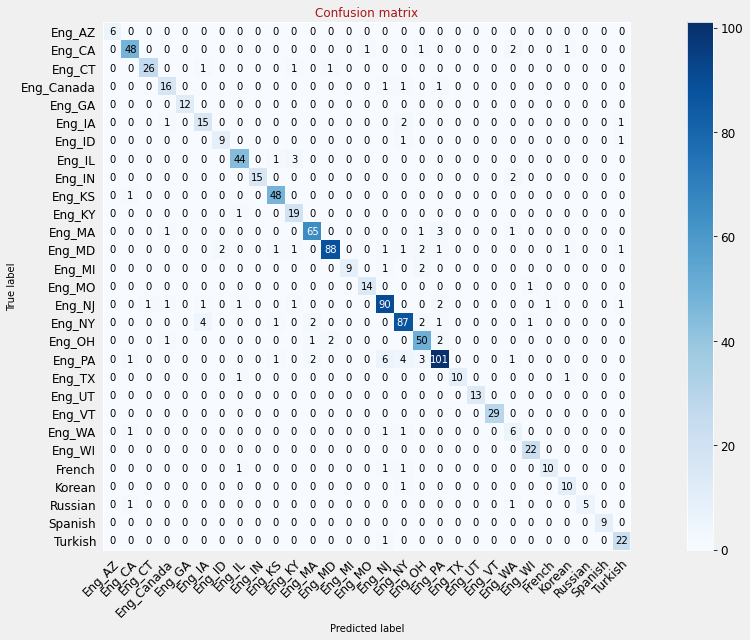

In [58]:
np.set_printoptions(precision=2)

# Plot non-normalized confusion matrix
plot_confusion_matrix(y_test, predicted_classes, classes=label_map,
                      title='Confusion matrix')

# # Plot normalized confusion matrix
# plot_confusion_matrix(y_test, predicted_classes, classes=label_map, normalize=True,
#                       title='Normalized confusion matrix')

plt.show()